# Analysis of Long Horizon Forcasting (~13 weeks horizon prediction)

* Initially we explore the capability of LightGBM and TimesFM model for forecasting future sales for various products across different clients and warehouses, using historical sales and pricing data. We utilized VN1 forecasting challenge dataset for the experimental purposes

### Setting Environments

In [ ]:
conda create --name long1 python=3.11.0 
conda activate long1
pip install -r requirements.txt
pip install ipykernel 
python -m ipykernel install --user --name  long1 --display-name "long1" 

In [30]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import AutoDifferences
from mlforecast.lag_transforms import (
    RollingMean, RollingStd, RollingMin, RollingMax, RollingQuantile,
    SeasonalRollingMean, SeasonalRollingStd, SeasonalRollingMin,
    SeasonalRollingMax, SeasonalRollingQuantile,ExpandingStd, ExponentiallyWeightedMean,
    ExpandingMean)

from functools import reduce
from utilsforecast.losses import smape, mase
import timesfm
import warnings
warnings.filterwarnings('ignore')

In [31]:
# ignore some warnings produced by mlforecast
warnings.filterwarnings("ignore", message=r".*Found null values.*")
warnings.filterwarnings("ignore", message=r"The following series are too short.*")

In [32]:
models = [
    lgb.LGBMRegressor(verbosity=-1)
]

mlf = MLForecast(
    models=models,
    freq='W-MON',
    lags=[1,4,8,13,26],

    lag_transforms={
        1: [ExpandingMean()],
        4: [RollingMean(window_size=4), RollingMean(window_size=13)],
        8: [RollingMean(window_size=4), RollingMean(window_size=13)],
        13: [RollingMean(window_size=4), RollingMean(window_size=13)],
    },
    date_features=['year', 'month', 'day', 'quarter'],
    target_transforms=[AutoDifferences(max_diffs=2)])

In [33]:

train = pd.read_csv("VN1_train.csv")
test = pd.read_csv("VN1_test.csv")
train['ds'] = pd.to_datetime(train['ds'])
test['ds'] = pd.to_datetime(test['ds'])


In [34]:
%%time
mlf.fit(
    train,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=[]
)
     


CPU times: user 42.8 s, sys: 57.8 ms, total: 42.8 s
Wall time: 895 ms


MLForecast(models=[LGBMRegressor], freq=W-MON, lag_features=['lag1', 'lag4', 'lag8', 'lag13', 'lag26', 'expanding_mean_lag1', 'rolling_mean_lag4_window_size4', 'rolling_mean_lag4_window_size13', 'rolling_mean_lag8_window_size4', 'rolling_mean_lag8_window_size13', 'rolling_mean_lag13_window_size4', 'rolling_mean_lag13_window_size13'], date_features=['year', 'month', 'day', 'quarter'], num_threads=1)

In [35]:
future_df=test.copy()

In [36]:
horizon=13
mlforecast = mlf.predict(horizon, X_df=future_df)

# Upcoming 13 Weeks Forecast

In [37]:
mlforecast.head()


,unique_id,ds,LGBMRegressor
0,C0_W100_P10705,2023-10-09,2.833747
1,C0_W100_P10705,2023-10-16,3.244078
2,C0_W100_P10705,2023-10-23,3.194867
3,C0_W100_P10705,2023-10-30,3.722241
4,C0_W100_P10705,2023-11-06,3.609787


In [38]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          context_len=128,
          input_patch_len=32,
          per_core_batch_size=128,
          horizon_len=13,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
  )

Fetching 3 files: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25165.82it/s]


In [39]:
%%time
timesfm_df = tfm.forecast_on_df(
    inputs=train,
    freq='W',
    value_name='y',
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
CPU times: user 20.2 s, sys: 4 s, total: 24.2 s
Wall time: 5.52 s


# Upcoming 13 Weeks Forecast

In [40]:
timesfm_df

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,C0_W100_P10705,2023-10-08,3.858518,1.752995,2.595696,3.058735,3.451719,3.858518,4.201731,4.710756,5.213253,5.984468
1,C0_W100_P10705,2023-10-15,3.937636,1.370208,2.320281,2.958747,3.457389,3.937636,4.392351,4.968751,5.412702,6.381108
2,C0_W100_P10705,2023-10-22,3.655196,1.066037,1.998929,2.723173,3.229338,3.655196,4.210047,4.774472,5.360648,6.290143
3,C0_W100_P10705,2023-10-29,3.705780,0.958355,2.042086,2.647297,3.221423,3.705780,4.189914,4.641141,5.291760,6.163414
4,C0_W100_P10705,2023-11-05,3.555774,0.853830,1.887523,2.474765,3.045985,3.555774,4.110613,4.544358,5.163644,6.054344
...,...,...,...,...,...,...,...,...,...,...,...,...
53269,C7_W303_P8795,2023-12-03,0.416000,-0.126512,-0.007119,0.126506,0.202160,0.416000,0.626916,0.912925,1.448799,2.529811
53270,C7_W303_P8795,2023-12-10,0.349842,-0.144285,-0.020338,0.091100,0.206778,0.349842,0.607386,0.909015,1.466802,2.623657
53271,C7_W303_P8795,2023-12-17,0.388702,-0.172077,-0.005504,0.107318,0.233586,0.388702,0.597715,0.959145,1.507382,2.687612
53272,C7_W303_P8795,2023-12-24,0.453597,-0.083484,0.020044,0.143810,0.312043,0.453597,0.680734,1.039499,1.624027,2.812088


In [41]:
timesfm_df['ds'] = pd.to_datetime(timesfm_df['ds'])
timesfm_df['ds'] = timesfm_df['ds'] + pd.DateOffset(days=1)

In [42]:
timesfm_df

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,C0_W100_P10705,2023-10-09,3.858518,1.752995,2.595696,3.058735,3.451719,3.858518,4.201731,4.710756,5.213253,5.984468
1,C0_W100_P10705,2023-10-16,3.937636,1.370208,2.320281,2.958747,3.457389,3.937636,4.392351,4.968751,5.412702,6.381108
2,C0_W100_P10705,2023-10-23,3.655196,1.066037,1.998929,2.723173,3.229338,3.655196,4.210047,4.774472,5.360648,6.290143
3,C0_W100_P10705,2023-10-30,3.705780,0.958355,2.042086,2.647297,3.221423,3.705780,4.189914,4.641141,5.291760,6.163414
4,C0_W100_P10705,2023-11-06,3.555774,0.853830,1.887523,2.474765,3.045985,3.555774,4.110613,4.544358,5.163644,6.054344
...,...,...,...,...,...,...,...,...,...,...,...,...
53269,C7_W303_P8795,2023-12-04,0.416000,-0.126512,-0.007119,0.126506,0.202160,0.416000,0.626916,0.912925,1.448799,2.529811
53270,C7_W303_P8795,2023-12-11,0.349842,-0.144285,-0.020338,0.091100,0.206778,0.349842,0.607386,0.909015,1.466802,2.623657
53271,C7_W303_P8795,2023-12-18,0.388702,-0.172077,-0.005504,0.107318,0.233586,0.388702,0.597715,0.959145,1.507382,2.687612
53272,C7_W303_P8795,2023-12-25,0.453597,-0.083484,0.020044,0.143810,0.312043,0.453597,0.680734,1.039499,1.624027,2.812088


In [43]:
from functools import reduce

#Merge All Results
data_frames = [mlforecast, timesfm_df ]
final_forecast_weekly_merged = reduce(lambda  left,right: pd.merge(left,right,on=['unique_id', 'ds'],how='inner'), data_frames)
     


In [44]:
final_forecast_weekly_merged

,unique_id,ds,LGBMRegressor,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,C0_W100_P10705,2023-10-09,2.833747,3.858518,1.752995,2.595696,3.058735,3.451719,3.858518,4.201731,4.710756,5.213253,5.984468
1,C0_W100_P10705,2023-10-16,3.244078,3.937636,1.370208,2.320281,2.958747,3.457389,3.937636,4.392351,4.968751,5.412702,6.381108
2,C0_W100_P10705,2023-10-23,3.194867,3.655196,1.066037,1.998929,2.723173,3.229338,3.655196,4.210047,4.774472,5.360648,6.290143
3,C0_W100_P10705,2023-10-30,3.722241,3.705780,0.958355,2.042086,2.647297,3.221423,3.705780,4.189914,4.641141,5.291760,6.163414
4,C0_W100_P10705,2023-11-06,3.609787,3.555774,0.853830,1.887523,2.474765,3.045985,3.555774,4.110613,4.544358,5.163644,6.054344
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53269,C7_W303_P8795,2023-12-04,4.212917,0.416000,-0.126512,-0.007119,0.126506,0.202160,0.416000,0.626916,0.912925,1.448799,2.529811
53270,C7_W303_P8795,2023-12-11,3.681597,0.349842,-0.144285,-0.020338,0.091100,0.206778,0.349842,0.607386,0.909015,1.466802,2.623657
53271,C7_W303_P8795,2023-12-18,3.682504,0.388702,-0.172077,-0.005504,0.107318,0.233586,0.388702,0.597715,0.959145,1.507382,2.687612
53272,C7_W303_P8795,2023-12-25,2.096700,0.453597,-0.083484,0.020044,0.143810,0.312043,0.453597,0.680734,1.039499,1.624027,2.812088


In [45]:
final_forecast_weekly_merged.to_csv("final_forecast_weekly_merged.csv")


In [46]:
train = pd.read_csv("VN1_train.csv")
actuals=pd.read_csv("Test_Weekly_VN1_Actuals_final.csv")
forecast=pd.read_csv("final_forecast_weekly_merged.csv")

In [47]:
train["ds"]=pd.to_datetime(train["ds"])
actuals["ds"]=pd.to_datetime(actuals["ds"])
forecast["ds"]=pd.to_datetime(forecast["ds"])

In [48]:
def evaluate(train, actuals, forecast, seasonality=52, id_col='unique_id', target_col='y'):
  fcst_and_actuals = pd.merge(actuals, forecast, on=['ds', 'unique_id'], how='left')
  models=["LGBMRegressor","timesfm"]
  mase_val = mase(fcst_and_actuals, models=models, seasonality=seasonality, train_df=train, id_col='unique_id', target_col='y')
  mase_val = mase_val.mean(numeric_only=True)
  smape_val = smape(fcst_and_actuals, models=models,  id_col='unique_id', target_col='y')
  smape_val = smape_val.mean(numeric_only=True)
  results = pd.DataFrame({'mase': mase_val, 'smape': smape_val}, index=models)
  results.index.name = 'models'
  results = results.round(4)
  return results

In [49]:
weekly_results=evaluate(train, actuals, forecast, seasonality=52, id_col='unique_id', target_col='y')

## RESULTS

In [50]:
weekly_results

,mase,smape
models,,
LGBMRegressor,0.2888,0.1551
timesfm,0.1980,0.1471


## VISUALIZATION

In [65]:
# Select a random unique_id from the forecast DataFrame
random_unique_id = random.choice(forecast['unique_id'].unique().tolist())


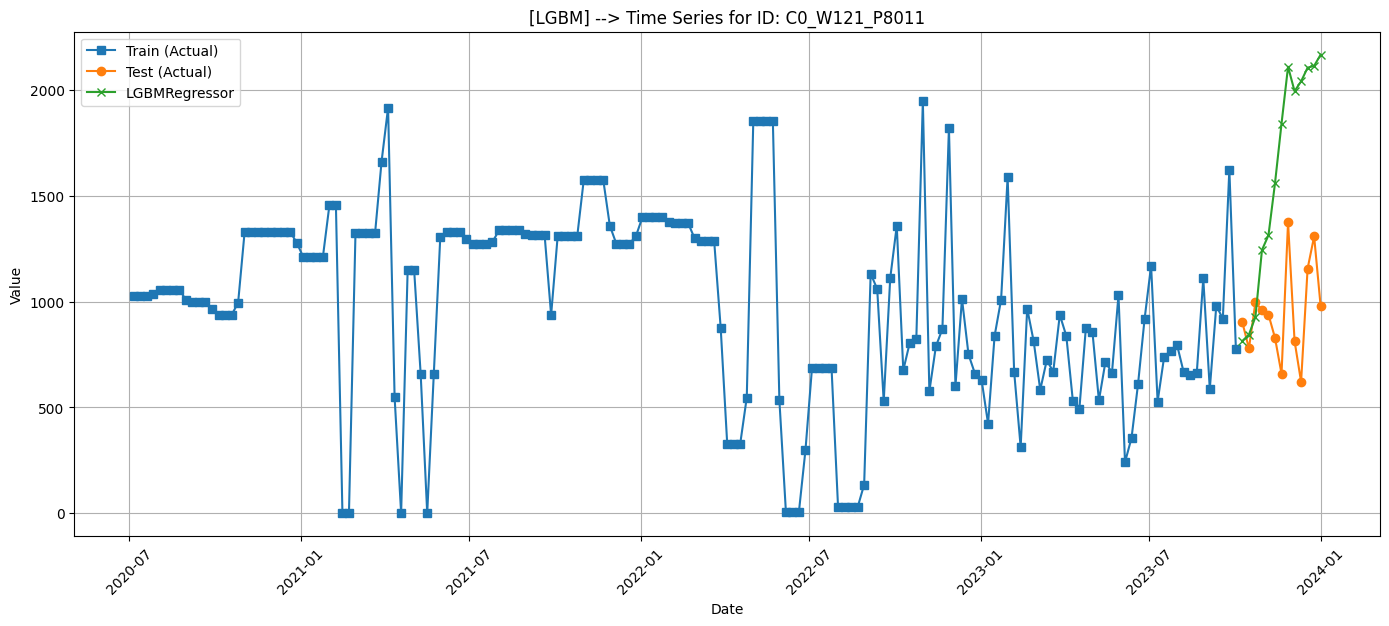

In [66]:
import random
import matplotlib.pyplot as plt

# Filter data for the selected random unique_id
target_id = random_unique_id
actuals_filtered = actuals[actuals['unique_id'] == target_id]
forecast_filtered = forecast[forecast['unique_id'] == target_id]
train_filtered = train[train['unique_id'] == target_id]

# Plotting all series together
plt.figure(figsize=(14, 6))
plt.plot(train_filtered['ds'], train_filtered['y'], label='Train (Actual)', marker='s')
plt.plot(actuals_filtered['ds'], actuals_filtered['y'], label='Test (Actual)', marker='o')
plt.plot(forecast_filtered['ds'], forecast_filtered['LGBMRegressor'], label='LGBMRegressor', marker='x')

plt.title(f"[LGBM] --> Time Series for ID: {target_id}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


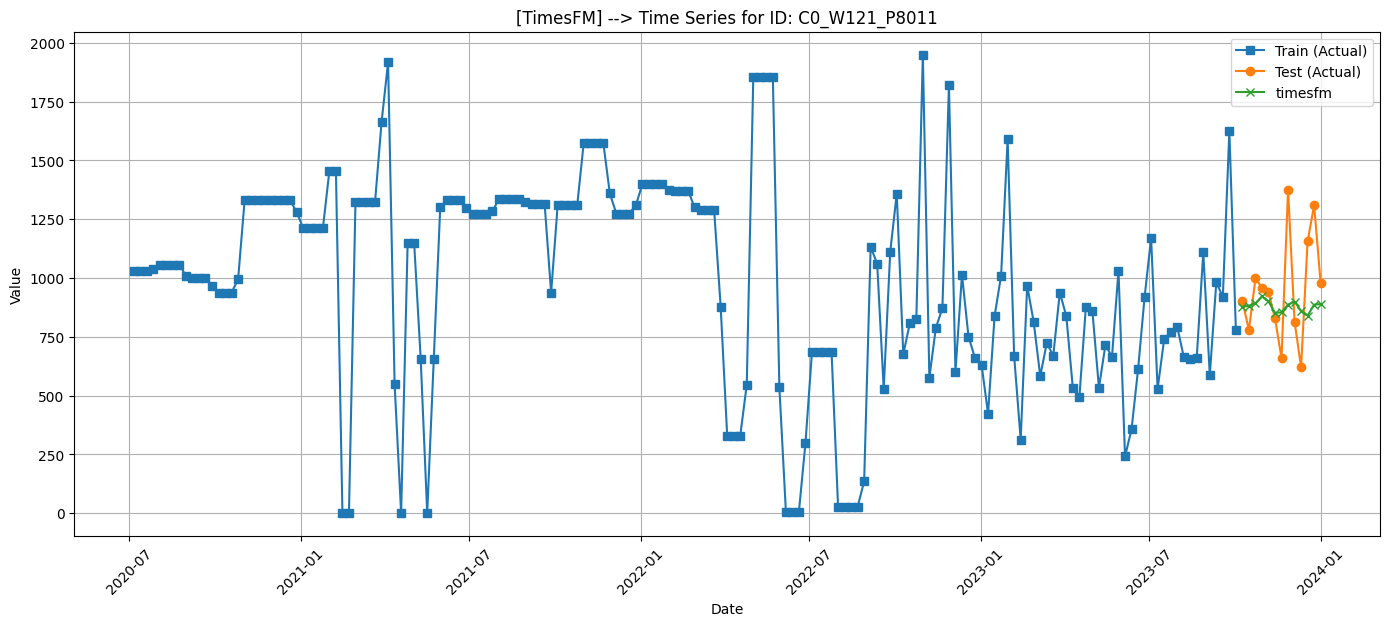

In [67]:
import random
import matplotlib.pyplot as plt


# Filter data for the selected random unique_id
target_id = random_unique_id
actuals_filtered = actuals[actuals['unique_id'] == target_id]
forecast_filtered = forecast[forecast['unique_id'] == target_id]
train_filtered = train[train['unique_id'] == target_id]

# Plotting all series together
plt.figure(figsize=(14, 6))
plt.plot(train_filtered['ds'], train_filtered['y'], label='Train (Actual)', marker='s')
plt.plot(actuals_filtered['ds'], actuals_filtered['y'], label='Test (Actual)', marker='o')
plt.plot(forecast_filtered['ds'], forecast_filtered['timesfm'], label='timesfm', marker='x')

plt.title(f"[TimesFM] --> Time Series for ID: {target_id}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

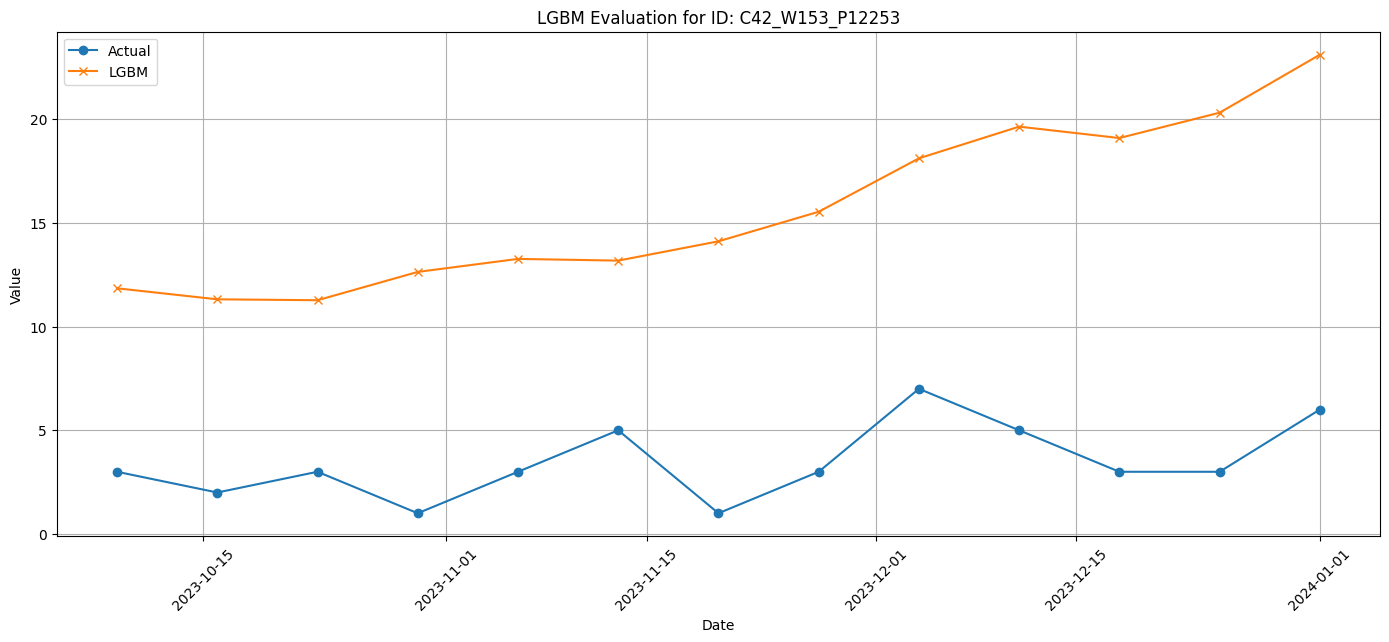

In [55]:
target_id = random_unique_id
actuals_filtered = actuals[actuals['unique_id'] == target_id]
forecast_filtered = forecast[forecast['unique_id'] == target_id]

# Plotting the time series evaluation
plt.figure(figsize=(14, 6))
plt.plot(actuals_filtered['ds'], actuals_filtered['y'], label='Actual', marker='o')
plt.plot(forecast_filtered['ds'], forecast_filtered['LGBMRegressor'], label='LGBM', marker='x')

plt.title(f"LGBM Evaluation for ID: {target_id}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

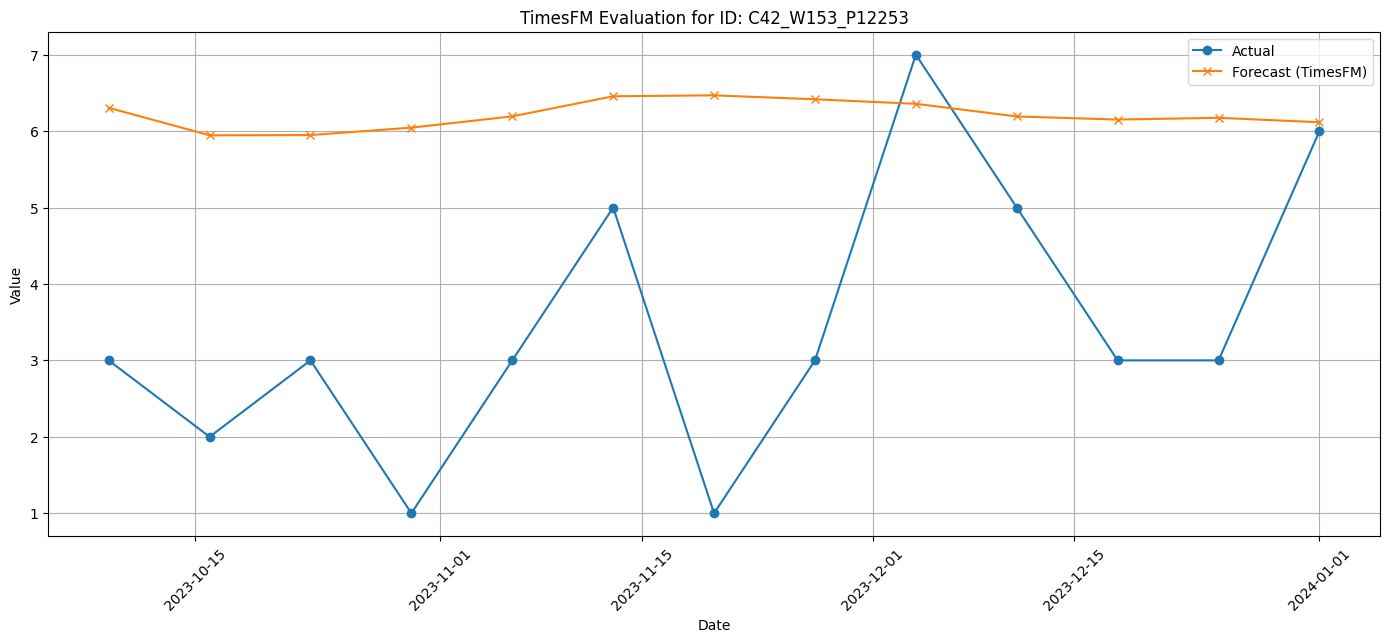

In [57]:

target_id = random_unique_id
actuals_filtered = actuals[actuals['unique_id'] == target_id]
forecast_filtered = forecast[forecast['unique_id'] == target_id]

# Plotting the time series evaluation
plt.figure(figsize=(14, 6))
plt.plot(actuals_filtered['ds'], actuals_filtered['y'], label='Actual', marker='o')
plt.plot(forecast_filtered['ds'], forecast_filtered['timesfm'], label='Forecast (TimesFM)', marker='x')

plt.title(f"TimesFM Evaluation for ID: {target_id}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()